In [ ]:
import os
import json
import torch
import re
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from peft import PeftModel

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [ ]:
PRM_ADAPTER_REPO = "devangb4/prm-qwen3-8b-bf16-6k"
BASE_MODEL_NAME = "Qwen/Qwen3-8B"
GENERATOR_MODEL = "Qwen/Qwen3-0.6B" # Or "Qwen/Qwen2.5-Math-1.5B-Instruct"

In [ ]:
NUM_PROBLEMS = 250         # Size of GSM8K subset
MAX_N_SAMPLES = 64         # Maximum budget to generate (we will slice this later)
BUDGETS_TO_TEST = [1, 2, 4, 8, 16, 32, 64] # The X-axis of our plot
OUTPUT_FILE = "efficiency_curve_data_250.jsonl"

### MODEL LOADING

In [ ]:
prm_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    device_map="cuda",
    dtype=DTYPE,
    trust_remote_code=True,
)
prm_model = PeftModel.from_pretrained(prm_base, PRM_ADAPTER_REPO)
prm_tok = AutoTokenizer.from_pretrained(PRM_ADAPTER_REPO, trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/876 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/61.4M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
hidden_size = prm_model.config.hidden_size
prm_head = torch.nn.Linear(hidden_size, 1).to(DEVICE).to(DTYPE)
# Try to load head weights (handling potential path issues)
try:
    from huggingface_hub import snapshot_download
    local_dir = snapshot_download(PRM_ADAPTER_REPO)
    head_path = os.path.join(local_dir, "prm_head.bin")
    if os.path.exists(head_path):
        prm_head.load_state_dict(torch.load(head_path, map_location=DEVICE))
        print("PRM Head loaded successfully.")
    else:
        print("WARNING: prm_head.bin not found. Using random init (BAD for results).")
except Exception as e:
    print(f"WARNING: Could not load PRM head weights: {e}")

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

prm_head_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

export_metadata.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

prm_head.bin:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/123M [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

PRM Head loaded successfully.


In [ ]:
gen_tok = AutoTokenizer.from_pretrained(GENERATOR_MODEL, trust_remote_code=True)
gen_model = AutoModelForCausalLM.from_pretrained(
    GENERATOR_MODEL,
    device_map="cuda",
    dtype=DTYPE,
    trust_remote_code=True
).eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

###Helpers

In [ ]:
def extract_answer(text):
    if not text: return ""
    # 1. Try finding 'Final Answer:'
    m = re.search(r"Final\s*Answer\s*:\s*(.+)", text, flags=re.I)
    ans = m.group(1).strip() if m else text.strip()

    # 2. Cleanup
    ans = ans.replace(",", "")
    ans = re.sub(r"\s*(mph|km/h|units?|percent|percentage|%|\$)", "", ans, flags=re.I)
    while ans.startswith("$"): ans = ans[1:]

    # 3. Extract last number
    nums = re.findall(r"-?\d+(?:\.\d+)?", ans)
    return nums[-1] if nums else ans

In [ ]:
def is_correct(gold, pred):
    """Check correctness with float tolerance."""
    try:
        return abs(float(gold) - float(pred)) < 1e-6
    except:
        return str(gold).strip() == str(pred).strip()

In [ ]:
def split_into_steps(text):
    """Split reasoning chain into steps based on 'Step X' headers."""
    # Regex to find "Step 1:", "**Step 1**", "#### Step 1"
    pattern = re.compile(r"^(?P<header>(?:\s*Step\s*\d+|\*\*Step\s*\d+\*\*|####\s*Step\s*\d+)[:.)-]?\s*)", re.IGNORECASE | re.MULTILINE)
    matches = list(pattern.finditer(text))

    if not matches:
        # Fallback to sentence splitting if no headers
        return [s.strip() for s in re.split(r"(?<=[.!?])\s+", text) if s.strip()]

    steps = []
    # Text before first step (usually intro)
    if matches[0].start() > 0:
        intro = text[:matches[0].start()].strip()
    else:
        intro = ""

    for i, match in enumerate(matches):
        start = match.start()
        end = matches[i+1].start() if i + 1 < len(matches) else len(text)
        content = text[start:end].strip()

        # Prepend intro to first step if it exists
        if i == 0 and intro:
            # Remove header from content to clean up, then re-attach
            header = match.group("header")
            body = content[len(header):].strip()
            content = f"{header} {intro} {body}"

        steps.append(content)
    return steps

In [ ]:
def format_step_prm(problem, prev_steps, current_step):
    """Format prompt for PRM verification."""
    prev_text = " ".join(prev_steps).strip()

    # Clean strict step headers for the prompt
    clean_step = re.sub(r"^\s*Step\s*\d+[:)]\s*", "", current_step).strip()

    if prev_text:
        return f"Problem: {problem}\nPrevious steps: {prev_text}\nCurrent step: {clean_step}\nIs this step correct?"
    else:
        return f"Problem: {problem}\nCurrent step: {clean_step}\nIs this step correct?"

In [ ]:
@torch.inference_mode()
def score_steps_batch(prompts):
    """Score a batch of steps using the PRM."""
    inputs = prm_tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)

    outputs = prm_model(**inputs, output_hidden_states=True, use_cache=False)
    # Get last hidden state of the last token
    last_hidden = outputs.hidden_states[-1] # [B, T, H]

    # Find the index of the last token (ignoring padding)
    # attention_mask is 1 for real tokens, 0 for pad. sum()-1 gives index of last real token.
    last_indices = inputs.attention_mask.sum(dim=1) - 1

    # Gather the hidden states
    # shape: [B, H]
    relevant_hidden = last_hidden[torch.arange(last_hidden.size(0), device=DEVICE), last_indices]

    logits = prm_head(relevant_hidden.to(prm_head.weight.dtype)).squeeze(-1)
    probs = torch.sigmoid(logits.float()).cpu().tolist()
    return probs

###Data Generation

In [ ]:
def build_prompt(problem):
    example_problem = "A train travels at 60 mph for 2 hours and then at 40 mph for 1 hour. What is the train's average speed for the entire journey?"

    example_solution = (
        "Step 1: Calculate the distance traveled during the first part of the journey.\n"
        "Distance1 = speed * time = 60 mph * 2 hours = 120 miles.\n"
        "Step 2: Calculate the distance traveled during the second part of the journey.\n"
        "Distance2 = speed * time = 40 mph * 1 hour = 40 miles.\n"
        "Step 3: Calculate the total distance traveled.\n"
        "Total Distance = Distance1 + Distance2 = 120 miles + 40 miles = 160 miles.\n"
        "Step 4: Calculate the total time taken for the journey.\n"
        "Total Time = Time1 + Time2 = 2 hours + 1 hour = 3 hours.\n"
        "Step 5: Calculate the average speed for the entire journey.\n"
        "Average Speed = Total Distance / Total Time = 160 miles / 3 hours = 53.33 mph.\n"
        "Final Answer: 53.33"
    )

    return (
        "You are a careful math tutor. Solve the problem in clear, numbered steps exactly as shown in the example. STRICTLY FOLLOW THE FORMAT\n\n"
        "### Example Problem:\n"
        f"{example_problem}\n"
        "### Example Solution:\n"
        f"{example_solution}\n\n"
        "--- END OF EXAMPLE ---\n\n"
        "### New Problem:\n"
        f"{problem}\n"
        "### Your Solution:\n"
    )

In [ ]:
def run_generation_and_scoring(existing_data=None):
    print(f"--> Loading GSM8K test set...")
    ds = load_dataset("gsm8k", "main", split="test")

    # Select 250 random indices (fixed seed for reproducibility)
    rng = random.Random(42)
    indices = rng.sample(range(len(ds)), NUM_PROBLEMS)
    subset = ds.select(indices)

    # Initialize stats
    running_correct_sc = 0
    running_total = 0

    if existing_data is None:
        results_buffer = []
        start_idx = 0
    else:
        results_buffer = existing_data
        start_idx = len(existing_data)
        print(f"--> Resuming from problem index {start_idx} (Buffer size: {len(results_buffer)})")

        # Pre-calculate stats for existing data to make the progress bar accurate
        for item in results_buffer:
            running_total += 1
            preds = [c['pred'] for c in item['candidates'] if c['pred']]
            if preds:
                most_common = Counter(preds).most_common(1)[0][0]
                if is_correct(item['gold'], most_common):
                    running_correct_sc += 1

    print(f"--> Starting Generation Loop for {NUM_PROBLEMS} problems x {MAX_N_SAMPLES} samples...")

    pbar = tqdm(enumerate(subset), total=len(subset))
    for i, row in pbar:
        # Skip already processed problems
        if i < start_idx:
            continue

        problem = row['question']
        gold_ans = extract_answer(row['answer'])

        candidates = []

        # 1. Generate Candidates (Batch generation would be faster, but simple loop for safety)
        prompt = build_prompt(problem)
        inputs = gen_tok([prompt] * MAX_N_SAMPLES, return_tensors="pt", padding=True).to(DEVICE)

        with torch.inference_mode():
            gen_out = gen_model.generate(
                **inputs,
                max_new_tokens=300,
                temperature=0.7,
                do_sample=True,
                pad_token_id=gen_tok.pad_token_id
            )

        raw_texts = gen_tok.batch_decode(gen_out, skip_special_tokens=True)

        # 2. Process and Score Candidates
        problem_candidates_data = []
        valid_preds = [] # To track valid predictions for SC

        for text in raw_texts:
            # Remove prompt
            if prompt in text:
                sol_text = text.split(prompt)[1].strip()
            else:
                sol_text = text

            pred_ans = extract_answer(sol_text)
            if pred_ans:
                valid_preds.append(pred_ans)

            steps = split_into_steps(sol_text)

            # Skip if empty
            if not steps:
                problem_candidates_data.append({'text': sol_text, 'pred': pred_ans, 'score': 0.0, 'correct': False})
                continue

            # Prepare PRM prompts for this chain
            prm_prompts = []
            prev = []
            for step in steps:
                prm_prompts.append(format_step_prm(problem, prev, step))
                prev.append(step)

            # Score chain
            if prm_prompts:
                step_probs = score_steps_batch(prm_prompts)
                # AGGREGATION: Log Product (Geometric Mean approx)
                # sum(log(p)) is better for stability than product(p)
                log_sum = sum(math.log(p + 1e-10) for p in step_probs)
                final_score = math.exp(log_sum) # or just use log_sum directly for ranking
            else:
                final_score = 0.0

            is_cor = is_correct(gold_ans, pred_ans)

            problem_candidates_data.append({
                'text': sol_text,
                'pred': pred_ans,
                'score': final_score, # PRM Score
                'correct': is_cor
            })

        results_buffer.append({
            'problem_idx': i,
            'problem': problem,
            'gold': gold_ans,
            'candidates': problem_candidates_data
        })

        # Update Stats
        running_total += 1
        if valid_preds:
            most_common = Counter(valid_preds).most_common(1)[0][0]
            if is_correct(gold_ans, most_common):
                running_correct_sc += 1

        current_acc = running_correct_sc / running_total if running_total > 0 else 0
        pbar.set_postfix({'SC_Acc': f"{current_acc:.2%}"})

        # Periodic Save
        if (i+1) % 10 == 0:
            with open(OUTPUT_FILE, 'w') as f:
                for r in results_buffer:
                    f.write(json.dumps(r) + "\n")

    # Final save
    with open(OUTPUT_FILE, 'w') as f:
        for r in results_buffer:
            f.write(json.dumps(r) + "\n")

    return results_buffer

### Analysis

In [ ]:
def analyze_and_plot(data):
    sc_accuracies = []
    prm_accuracies = []

    for n in BUDGETS_TO_TEST:
        correct_sc = 0
        correct_prm = 0
        total = len(data)

        for item in data:
            pool = item['candidates'][:n]

            # --- Strategy 1: Self-Consistency (Majority Vote) ---
            preds = [c['pred'] for c in pool if c['pred']] # filter empty
            if preds:
                # Find most common answer
                most_common = Counter(preds).most_common(1)[0][0]
                if is_correct(item['gold'], most_common):
                    correct_sc += 1

            # --- Strategy 2: PRM Best-of-N (Re-ranking) ---
            # Sort pool by PRM score descending
            if pool:
                best_cand = sorted(pool, key=lambda x: x['score'], reverse=True)[0]
                if best_cand['correct']:
                    correct_prm += 1

        sc_acc = correct_sc / total
        prm_acc = correct_prm / total

        sc_accuracies.append(sc_acc)
        prm_accuracies.append(prm_acc)
        print(f"Budget N={n:<2} | SC: {sc_acc:.3f} | PRM: {prm_acc:.3f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(BUDGETS_TO_TEST, sc_accuracies, 'o-', label='Self-Consistency (Majority Vote)', color='blue', linewidth=2)
    plt.plot(BUDGETS_TO_TEST, prm_accuracies, 's-', label='PRM (Best-of-N)', color='red', linewidth=2)

    plt.xscale('log', base=2)
    plt.xlabel('Compute Budget (Number of Generated Solutions)')
    plt.ylabel('Accuracy')
    plt.title(f'Compute Efficiency: PRM vs. Self-Consistency (GSM8K n={len(data)})')
    plt.xticks(BUDGETS_TO_TEST, labels=[str(b) for b in BUDGETS_TO_TEST])
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    plot_path = "efficiency_curve.png"
    plt.savefig(plot_path)
    plt.show()

--> Loading GSM8K test set...


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

--> Starting Generation Loop for 250 problems x 64 samples...


  0%|          | 0/250 [00:00<?, ?it/s]

Budget N=1  | SC: 0.420 | PRM: 0.420
Budget N=2  | SC: 0.420 | PRM: 0.484
Budget N=4  | SC: 0.448 | PRM: 0.568
Budget N=8  | SC: 0.548 | PRM: 0.608
Budget N=16 | SC: 0.572 | PRM: 0.620
Budget N=32 | SC: 0.580 | PRM: 0.632
Budget N=64 | SC: 0.584 | PRM: 0.636
--> Plot saved to efficiency_curve.png


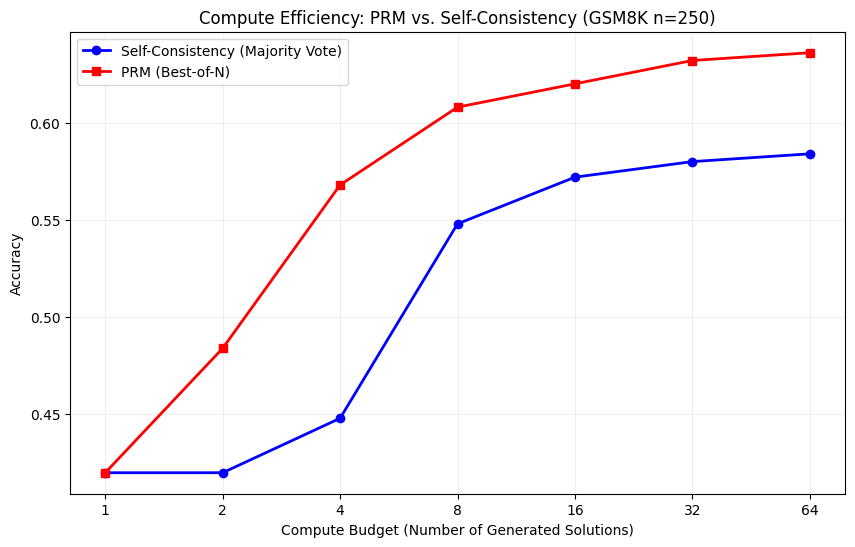

In [ ]:
if os.path.exists(OUTPUT_FILE):
    print(f"Found existing data file {OUTPUT_FILE}. Loading...")
    all_data = []
    try:
        with open(OUTPUT_FILE, 'r') as f:
            for line in f:
                if line.strip():
                    all_data.append(json.loads(line))
    except Exception as e:
        print(f"Error loading file: {e}. Starting fresh.")
        all_data = []

    if len(all_data) < NUM_PROBLEMS:
        print(f"Data incomplete ({len(all_data)}/{NUM_PROBLEMS}). Resuming generation...")
        data = run_generation_and_scoring(existing_data=all_data)
        analyze_and_plot(data)
    else:
        print("Data complete. Analyzing...")
        analyze_and_plot(all_data)
else:
    data = run_generation_and_scoring()
    analyze_and_plot(data)